# Mod 4 Project - Notebook

Jeremy Owens, Jeremy Reikes

# Step 1: Load the Data

In [1]:
import pandas as pd
import numpy as np
# import statsmodels as sm
import matplotlib.pyplot as plt
# import seaborn as sns
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
# from dateutil.relativedelta import relativedelta
import datetime as datetime
import warnings
from pmdarima.arima import auto_arima

from ProcessData import *
from narrow_zips import *
from arima_model import *

%matplotlib inline

In [2]:
initial_data = pd.read_csv('zillow_data.csv')
print(len(initial_data))
initial_data.head(5)

14723


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Step 2: Data Preprocessing

In [3]:
processed_data = ProcessData()

# Step 3: Reshape from Wide to Long Format

For comparison sake, we melt the initial data set below to look at the growth in home values over time for all zipcodes.

In [4]:
monthly_medians = processed_data.monthly_medians
time_series = processed_data.dataframes
zipcodes = processed_data.zipcodes

# Step 4: EDA and Visualization
Perform basic EDA as you would building any model, then create at least 3 visualizations.  At least one of the visualizations should have time on the x-axis.  Axes should be labeled and any text should be legible.

In [5]:
# start_date = '2010-01-01'
# end_of_collection = '2018-04-01'
# years_to_forecast = 5
# processed_data = ProcessData('2010-01-01')
# monthly_medians = processed_data.monthly_medians
# dataframes = processed_data.dataframes
# zipcodes = processed_data.zipcodes
# best_zips = get_best_zipcodes()

In [6]:
min(monthly_medians.values)

array([99500.])

We used http://www.in2013dollars.com/1996-dollars-in-2018?amount=99500 to get a table for inflation's effect on prices from 1996 (the beginning of our data set) to 2018 (the end of our dataset)

In [7]:
inflation_data = pd.read_csv('inflation_data.csv')
inflation_data['year'] = pd.to_datetime(inflation_data['year'], format='%Y')
inflation_data.drop('inflation rate', axis=1, inplace=True)
inflation_data.set_index('year', inplace=True)
inflation_data.head()

,amount
year,
1996-01-01,99500.000000
1997-01-01,101782.982792
1998-01-01,103368.387508
1999-01-01,105651.370300
2000-01-01,109202.676864


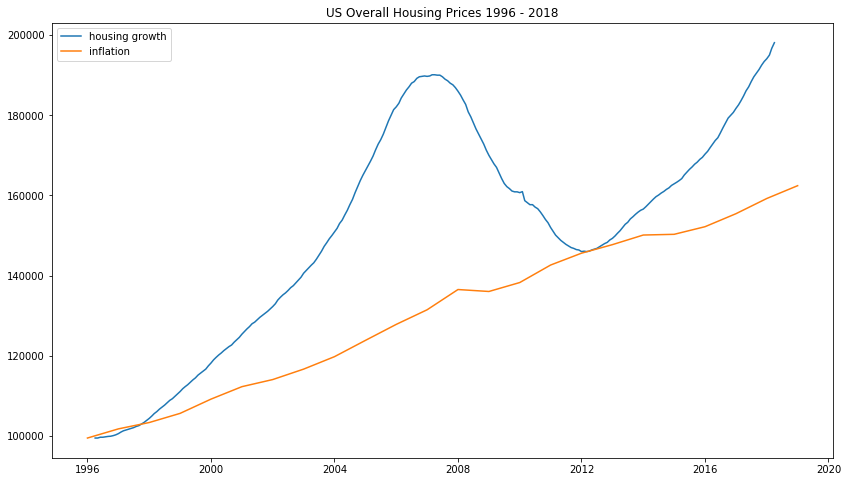

In [8]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(14,8))
plt.plot(monthly_medians, label='housing growth')
plt.plot(inflation_data, label='inflation')
plt.title('US Overall Housing Prices 1996 - 2018')
plt.legend()
plt.show()

In [9]:
raw_data = pd.io.parsers.read_csv('zillow_data.csv', dtype={'RegionName': 'str'})
widedata = raw_data
widedata.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [22]:
def plot_growth(start_year='2010', end_year='2018', top_or_bottom='top', how_many=5):
    percent_growth_by_zip = []
    for zipcode in time_series:
        percent_for_zip = (zipcode.loc[end_year].Price[0] - zipcode.loc[start_year].Price[0]) / zipcode.loc[start_year].Price[0]
        percent_growth_by_zip.append(percent_for_zip)
        
    start = 0
    end = len(percent_growth_by_zip)
    start = -how_many if top_or_bottom == 'top' else start
    end = how_many if top_or_bottom == 'bottom' else end
    
    indexes = sorted(range(len(percent_growth_by_zip)), 
                     key=lambda i: percent_growth_by_zip[i], reverse=False)[start:end]
    
    values_to_print = []
    plt.figure(figsize=(14,8))
    for i in indexes:
        values_to_print.append([zipcodes[i], percent_growth_by_zip[i]])
        label = zipcodes[i]+' - '+ \
                widedata[widedata.RegionName == zipcodes[i]]['City'].values[0]+', '+ \
                widedata[widedata.RegionName == zipcodes[i]]['State'].values[0]

        plt.plot(time_series[i][start_year:end_year].Price, label=label)
    plt.plot(monthly_medians[start_year:end_year], label='Median growth')
    plt.legend()
    plt.show
    for j in range(len(values_to_print)):
        print('Growth rate for zipcode', values_to_print[j][0], ':', round(values_to_print[j][1]*100, 2), '%')

Growth rate for zipcode 95824 : 169.02 %
Growth rate for zipcode 11222 : 173.1 %
Growth rate for zipcode 33056 : 174.15 %
Growth rate for zipcode 33936 : 181.25 %
Growth rate for zipcode 11216 : 214.2 %


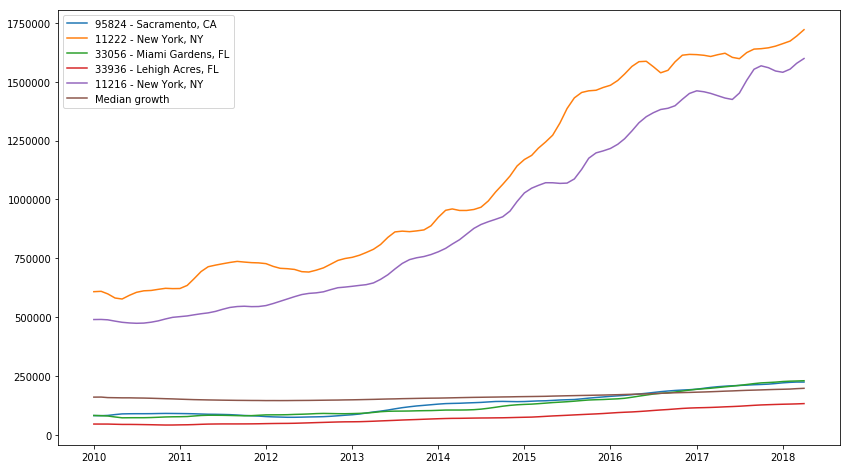

In [23]:
plot_growth(how_many=5)

Growth rate for zipcode 34982 : 115.93 %
Growth rate for zipcode 33801 : 115.96 %
Growth rate for zipcode 33056 : 116.81 %
Growth rate for zipcode 37210 : 119.52 %
Growth rate for zipcode 15213 : 128.43 %


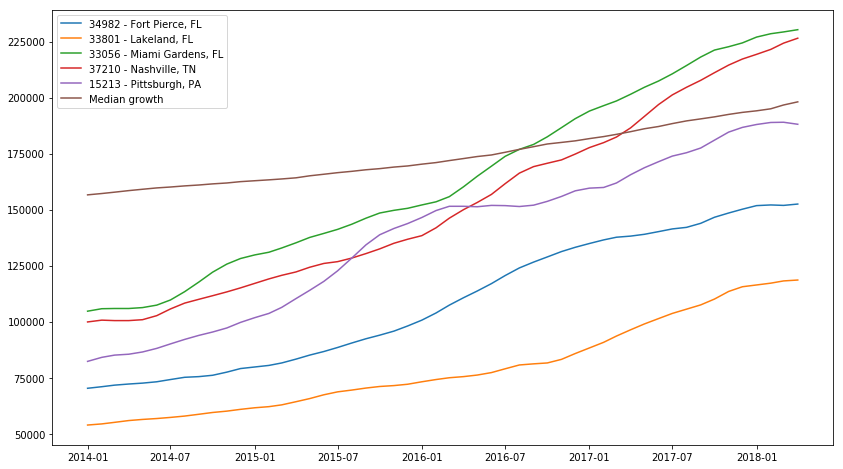

In [24]:
plot_growth(start_year='2014', end_year='2018', how_many=5)

# Step 5: ARIMA Modeling
Be sure to validate your model.  Make a forecast for the future and describe the trend.

In [33]:
best_zips = get_best_zipcodes(time_series)
best_zips

NameError: name 'dataframes' is not defined

# Step 6: Interpreting Results
Give a detailed interpretation of results including the relationship between the inputs and output of the model.

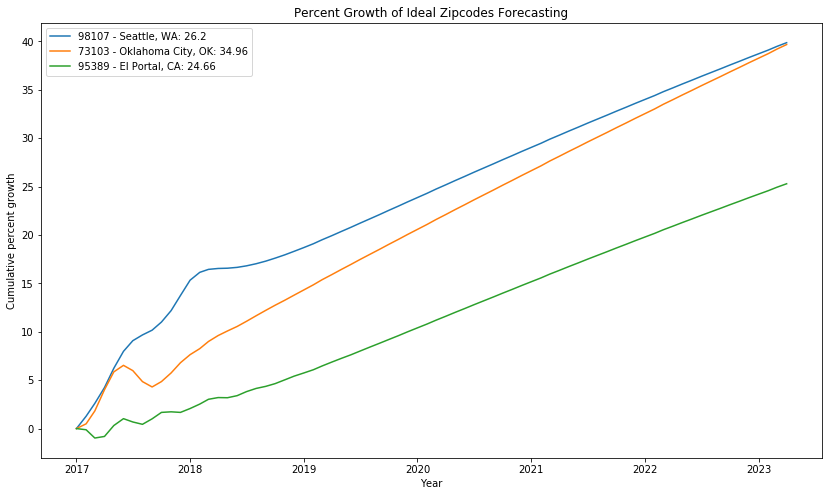

In [73]:
plt.figure(figsize=(14,8))
for zipcode in best_zips:
    percent_change_df = growth_entry['all_values']['2017':]
    percent_change = [0]
    for i in range(1, len(percent_change_df.values)):
        percent_change.append(100*((percent_change_df.values[i][0] - percent_change_df.values[i-1][0]) / percent_change_df.values[i-1][0]))
    percent_change_df['change'] = percent_change
    percent_change_df.drop('values', axis=1, inplace=True)
    percent_change_df = percent_change_df.cumsum()
    zipcode = growth_entry['zipcode']
    city = initial_data['City'][growth_entry['index']]
    state = initial_data['State'][growth_entry['index']]
    growth_rate = growth_entry['growth_predict']
    label = str(zipcode)+' - '+str(city)+', '+str(state)+': '+str(growth_rate)
    plt.plot(percent_change_df, label=label)
plt.ylabel('Cumulative percent growth')
plt.xlabel('Year')
plt.title('Percent Growth of Ideal Zipcodes Forecasting')
plt.legend()
plt.show()

# Working Zone

In [5]:
# to view all NaN values for median housing price in zip code
columns = list(initial_data.columns)
nans = list(initial_data.isna().sum())
for item in zip(columns, nans):
    print(item)

('RegionID', 0)
('RegionName', 0)
('City', 0)
('State', 0)
('Metro', 1043)
('CountyName', 0)
('SizeRank', 0)
('1996-04', 1039)
('1996-05', 1039)
('1996-06', 1039)
('1996-07', 1039)
('1996-08', 1039)
('1996-09', 1039)
('1996-10', 1039)
('1996-11', 1039)
('1996-12', 1039)
('1997-01', 1039)
('1997-02', 1039)
('1997-03', 1039)
('1997-04', 1039)
('1997-05', 1039)
('1997-06', 1039)
('1997-07', 1038)
('1997-08', 1038)
('1997-09', 1038)
('1997-10', 1038)
('1997-11', 1038)
('1997-12', 1038)
('1998-01', 1036)
('1998-02', 1036)
('1998-03', 1036)
('1998-04', 1036)
('1998-05', 1036)
('1998-06', 1036)
('1998-07', 1036)
('1998-08', 1036)
('1998-09', 1036)
('1998-10', 1036)
('1998-11', 1036)
('1998-12', 1036)
('1999-01', 1036)
('1999-02', 1036)
('1999-03', 1036)
('1999-04', 1036)
('1999-05', 1036)
('1999-06', 1036)
('1999-07', 1036)
('1999-08', 1036)
('1999-09', 1036)
('1999-10', 1036)
('1999-11', 1036)
('1999-12', 1036)
('2000-01', 1036)
('2000-02', 1036)
('2000-03', 1036)
('2000-04', 1036)
('2000-05

In [11]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 
                                  'CountyName', 'RegionID', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    return melted.groupby('time').agg({'value':'median'})

In [ ]:
for zipcode in time_series:
    for i in range(1, len(zipcode)+1):
        if zipcode.iloc[-i].values == 0:
            zipcode.iloc[-i] = round(float(zipcode.iloc[-i+1].values * (melted_data.iloc[-i].values / 
                                                                        melted_data.iloc[-i+1].values)), 0)

In [ ]:
percent_growth_by_zip = []
for zipcode in time_series:
    percent_for_zip = zipcode.loc['1996'].values[0][0] / zipcode.loc['2008'].values[0][0]
    percent_growth_by_zip.append(percent_for_zip)

In [ ]:
indexes = sorted(range(len(percent_growth_by_zip)), key=lambda i: percent_growth_by_zip[i], reverse=True)[:5]
indexes

In [ ]:
plt.figure(figsize=(14,8))
for i in indexes:
    plt.plot(time_series[i], label=str(zipcodes[i]))
plt.plot(monthly_medians, label='median growth')
plt.legend()
plt.show

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0, 13)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

In [137]:
# evaluate parameters
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(time_series[0], p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=22524201798.709
ARIMA(0, 0, 1) MSE=5644131313.729
ARIMA(0, 1, 0) MSE=15252790.551
ARIMA(0, 1, 1) MSE=6661495.112
ARIMA(0, 2, 0) MSE=11361751.352
ARIMA(0, 2, 1) MSE=7119207.778
ARIMA(1, 0, 0) MSE=25955172.117
ARIMA(1, 1, 0) MSE=9901379.810
ARIMA(1, 1, 1) MSE=5618165.173
ARIMA(1, 2, 0) MSE=9980796.512
ARIMA(1, 2, 1) MSE=7240391.272
ARIMA(1, 2, 2) MSE=6003944.604
ARIMA(2, 0, 0) MSE=10935372.639
ARIMA(2, 1, 0) MSE=6851567.523
ARIMA(2, 2, 0) MSE=6638567.862
ARIMA(2, 2, 1) MSE=6207464.714
ARIMA(2, 2, 2) MSE=5314251.194
ARIMA(3, 1, 1) MSE=5182165.450
ARIMA(3, 1, 2) MSE=3986375.863
ARIMA(3, 2, 0) MSE=6989774.563
ARIMA(3, 2, 1) MSE=6390995.761
ARIMA(4, 1, 0) MSE=5924929.777
ARIMA(4, 1, 1) MSE=5379103.854
ARIMA(4, 2, 0) MSE=4774411.464
ARIMA(4, 2, 1) MSE=5501008.573
ARIMA(4, 2, 2) MSE=5552039.614
ARIMA(5, 1, 0) MSE=4630496.045
ARIMA(5, 2, 0) MSE=5282916.710
ARIMA(5, 2, 1) MSE=5401434.905
ARIMA(6, 1, 0) MSE=5004262.883
ARIMA(6, 1, 1) MSE=4746351.866
ARIMA(6, 2, 0) MSE=5302217.7

In [5]:
def fix_zipcodes(zipcode):
    if len(zipcode) == 5:
        return zipcode
    else:
        return '0'+zipcode

In [7]:
cut_data = initial_data.drop(['RegionID', 'City', 'State', 'CountyName', 'SizeRank', 'Metro'], axis=1)
cut_data.rename({'RegionName': 'Zipcode'}, axis=1, inplace=True)
cut_data['Zipcode'] = cut_data.Zipcode.astype(str)
cut_data['Zipcode'] = cut_data['Zipcode'].apply(lambda z: fix_zipcodes(z))
cut_data.head()

In [4]:
initial_data[initial_data['2014-06'].isna()].head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
2946,73623,35810,Huntsville,AL,Huntsville,Madison,2947,NaN,NaN,NaN,...,61000,61000,61100,61900,62800,63200,63700,65200,67500,69400
3330,58630,2116,Boston,MA,Boston,Suffolk,3331,NaN,NaN,NaN,...,1931100,1995600,2031100,2049600,2057800,2064500,2037600,2056900,2106500,2136500
6153,73629,35816,Huntsville,AL,Huntsville,Madison,6154,NaN,NaN,NaN,...,61500,62500,62800,63300,64100,65100,66600,68700,70400,71300
7587,78091,46320,Hammond,IN,Chicago,Lake,7588,NaN,NaN,NaN,...,66000,67900,68200,68700,69600,69400,68500,68500,68200,67200
7635,78566,47371,Portland,IN,NaN,Jay,7636,NaN,NaN,NaN,...,86300,86600,87400,88200,89100,90300,90400,89100,88000,88100


In [12]:
monthly_medians = melt_data(initial_data)

In [ ]:
cut_data.columns = [cut_data.columns[0]] + list(get_datetimes(cut_data))

In [20]:
# zipcodes = []
# time_series = []
# for row in range(len(cut_data)):
#     zipcodes.append(cut_data.iloc[row]['Zipcode'])
#     series = pd.DataFrame(cut_data.iloc[row].iloc[1:]).rename({row:'values'}, axis=1)
#     time_series.append(series)

In [21]:
# for zipcode in time_series:
#     for j in range(len(zipcode)):
#         if np.isnan(zipcode.iloc[-1-j].values[0]):
#             base = zipcode.iloc[-j].values[0]
#             ratio = monthly_medians.iloc[-1-j].values[0] / monthly_medians.iloc[-j].values[0]
#             zipcode.iloc[-1-j] = round(base * ratio, 2)

In [29]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(time_series, arima_order):
    # prepare training dataset
    time_series_filtered = time_series.squeeze()
    train_size = int(len(time_series_filtered) * 0.66)
    train, test = time_series_filtered[0:train_size], time_series_filtered[train_size:]
    history = [x for x in train]
    
    # make predictions
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [30]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(time_series, p_values, d_values, q_values):
    time_series = time_series.astype('float32')
    best_score, best_cfg = 100000000.0, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(time_series, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [40]:
# warnings.filterwarnings("ignore")
# p_values = range(0, 4)
# d_values = range(0, 3)
# q_values = range(0, 3)

# # top_indexes should equal top_zipcodes from 

# best_post_crash_arima = []
# for index in top_indexes[:3]:
#     print('Index:', index, 'Zipcode:', zipcodes[index])
#     pdq = evaluate_models(time_series[index], p_values, d_values, q_values)
#     print()
#     best_post_crash_arima.append({'index': index, 'zipcode': zipcodes[index], 'pdq': pdq})

Index: 2157 Zipcode: 98107
Best ARIMA(2, 1, 1) MSE=3080377.116

Index: 9540 Zipcode: 73103
Best ARIMA(2, 2, 0) MSE=1722197.843

Index: 13591 Zipcode: 95389
Best ARIMA(3, 1, 1) MSE=4332267.626



In [42]:
future_growth_by_zip_5_year = []
for entry in best_post_crash_arima:
    history = time_series[entry['index']].astype('float32')['2010':].squeeze()
    model = ARIMA(history, order=entry['pdq'])
    model_fit = model.fit(disp=0)
    model_predict = model_fit.forecast(12*5)
    future_percent_for_zip = (model_predict[0][-1] - history[-1]) / history[-1]
    future_growth_by_zip_5_year.append({'index': entry['index'],
                                        'zipcode': entry['zipcode'],
                                        'growth_predict': round(future_percent_for_zip*100, 2),
                                        'growth_values': model_predict[0]})

{'index': 2157, 'zipcode': '98107', 'pdq': (2, 1, 1)}
{'index': 9540, 'zipcode': '73103', 'pdq': (2, 2, 0)}
{'index': 13591, 'zipcode': '95389', 'pdq': (3, 1, 1)}


In [47]:
datelist = pd.date_range(pd.datetime(2018,5,1), periods=12*5, freq='MS').tolist()

In [48]:
for growth_entry in future_growth_by_zip_5_year:
    temp_df = pd.DataFrame(zip(datelist, growth_entry['growth_values'])).set_index(0)
    history_future_df = pd.concat([time_series[growth_entry['index']], 
                                   temp_df.rename({1:'values'}, axis=1).astype('int32')])
    growth_entry['all_values'] = history_future_df